<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tracing-field-lines-and-computing-Poincare-sections" data-toc-modified-id="Tracing-field-lines-and-computing-Poincare-sections-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tracing field lines and computing Poincare sections</a></span></li><li><span><a href="#Generate-trajectories-on-$\Sigma^-$-for-the-toy-tokamak" data-toc-modified-id="Generate-trajectories-on-$\Sigma^-$-for-the-toy-tokamak-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generate trajectories on $\Sigma^-$ for the toy tokamak</a></span></li><li><span><a href="#Visualize-guiding-center-trajectories-in-2D-and-3D" data-toc-modified-id="Visualize-guiding-center-trajectories-in-2D-and-3D-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualize guiding center trajectories in 2D and 3D</a></span></li></ul></div>

In [1]:
import numpy as np

from matplotlib import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import rcParams

from scipy.integrate import solve_ivp

from importlib import reload  # Python 3.4+
import toy_tokamak
reload(toy_tokamak)

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)


tick_labelsize = 15 #10, 20
axes_labelsize = 20
mpl.rcParams['xtick.labelsize'] = tick_labelsize
mpl.rcParams['ytick.labelsize'] = tick_labelsize
mpl.rcParams['axes.labelsize'] = axes_labelsize

In [2]:
# parameters = [R0, C, epsilon] 
field_parameters = np.array([1, 5.5, 0.02, np.NaN], dtype = float)

## Tracing field lines and computing Poincare sections 

We use points from $\Sigma^-$

Text(0, 0.5, '$z$')

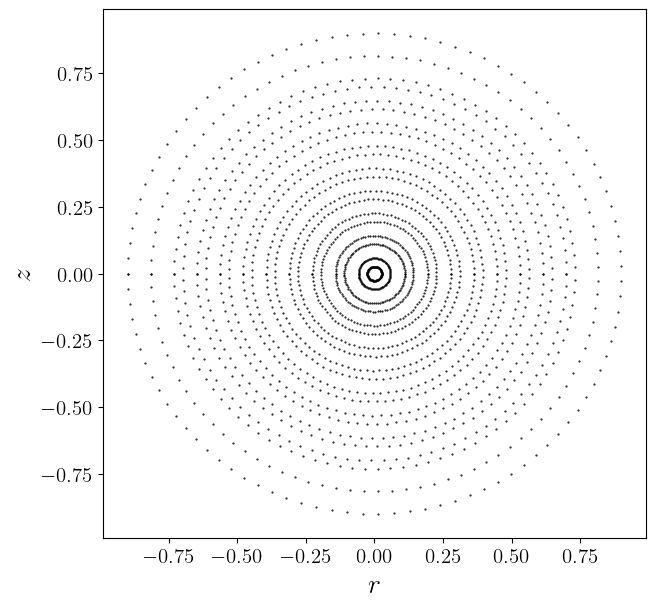

In [3]:
# Extract points on sigma for which phi = 0
resolution = 100
res_minorRad = 20
majorRad = 1 #R0
minorRad = 0.4 #r0
theta = np.pi/2 # toroidal angle
phi = np.linspace(-np.pi, np.pi, resolution) # poloidal angle
minorRadGrid = np.linspace(-0.7, 0.9, res_minorRad)
thetaMesh, phiMesh, minorRadMesh = np.meshgrid(theta, phi, minorRadGrid)
xMesh = (majorRad + minorRadMesh*np.cos(phiMesh))*np.cos(thetaMesh)
yMesh = (majorRad + minorRadMesh*np.cos(phiMesh))*np.sin(thetaMesh)
zMesh = minorRadMesh*np.sin(phiMesh)

xyzMesh = np.column_stack([np.reshape(xMesh, (resolution*np.size(theta)*res_minorRad)), \
                          np.reshape(yMesh, (resolution*np.size(theta)*res_minorRad)), \
                          np.reshape(zMesh, (resolution*np.size(theta)*res_minorRad))])
rMesh = np.linalg.norm(xyzMesh[:,:2], axis = 1) - field_parameters[0]

fig = plt.figure(figsize=(7,7), dpi = 100)
ax = fig.add_subplot()
# ax = fig.add_subplot(111, projection='3d')
plt.plot(rMesh, np.reshape(zMesh, (resolution*np.size(theta)*res_minorRad)), '.k', ms = 1)
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$z$')


In [5]:
def intersect_poloidalplane(t, y, *field_parameters):
    """
    Compute intersection of fieldlines with a poloidal plane defined
    by phi = constant where phi is the toroidal coordinate.
    """
    phi = np.arctan2(y[1], y[0])
    return phi - np.pi/2
intersect_poloidalplane.terminal = False
intersect_poloidalplane.direction = 1


# Converting to cartesian coordinates
sigmaMinus_xMesh = sigmaMinus[:,0]*np.cos(sigmaMinus[:,1])
sigmaMinus_yMesh = sigmaMinus[:,0]*np.sin(sigmaMinus[:,1])
sigmaMinus_zMesh = sigmaMinus[:,2]


poincare_sect_fieldlines = np.array([])

initcondID = 7000

# for initcondID in range(len(sigmaMinus_xMesh)):
for initcondID in range(np.size(xyzMesh,0)):
    # y0 = np.array([sigmaMinus_xMesh[initcondID], sigmaMinus_yMesh[initcondID], \
    #        sigmaMinus_zMesh[initcondID]])
    y0 = xyzMesh[initcondID,:]
    initialEnergy = toy_tokamak.field_mag(toy_tokamak.cart_to_cyl(np.reshape(y0[:3,], (1,3))), \
                                 field_parameters)
    print('Initial energy, h: %.16e'%(initialEnergy))

    # modBprime = toy_tokamak.dfieldmag_ds(sigmaMinus[initcondID,:], field_parameters)
    # print('d|B|/ds: %.16e'%(modBprime))

    field_parameters[-1] = initialEnergy
    sol = solve_ivp(toy_tokamak.fieldline_flow, [0, 10], y0, args = field_parameters, \
                    events = intersect_poloidalplane, dense_output = True, rtol=1e-8)

    if poincare_sect_fieldlines.size == 0:
        poincare_sect_fieldlines = np.append(np.reshape(sol.t_events[0][1:], (len(sol.t_events[0][1:]),1)), \
                                         sol.y_events[0][1:], axis = 1)
    else:
        poincare_sect_fieldlines = np.concatenate((poincare_sect_fieldlines, \
                                np.append(np.reshape(sol.t_events[0][1:], (len(sol.t_events[0][1:]),1)), \
                                sol.y_events[0][1:], axis = 1)), axis = 0)



NameError: name 'sigmaMinus' is not defined

In [4]:
%matplotlib

plt.figure(figsize = (7,7), dpi = 100)
# plt.scatter(np.arctan2(poincare_sect_fieldlines[:,2],poincare_sect_fieldlines[:,1]), \
#             poincare_sect_fieldlines[:,3], s = 1)
plt.scatter(np.linalg.norm(poincare_sect_fieldlines[:,1:3], axis = 1) - field_parameters[0], \
            poincare_sect_fieldlines[:,3], s = 1)

# plt.plot(np.arctan2(poincare_sect_fieldlines[:,2],poincare_sect_fieldlines[:,1]))

Using matplotlib backend: <object object at 0x7fae80d1f400>


NameError: name 'poincare_sect_fieldlines' is not defined

In [108]:
%matplotlib 

majorRad = field_parameters[0]
minorRad = 0.4 # check if the code for generating sigma has the same minor radii


dtEval = 0.01
tEval = np.arange(sol.t[0], sol.t[-1] + dtEval, dtEval)
solEval = sol.sol(tEval) #in cartesian coordinates


# ax.plot_surface(xMesh, yMesh, zMesh, alpha = 0.2, antialiased = True)
fig = plt.figure(figsize=(6,6), dpi=130)
ax = fig.add_subplot(111, projection='3d')
# ax.scatter3D(y0[0], y0[1], y0[2], s = 15)
ax.plot3D(solEval[0,:], solEval[1,:], solEval[2,:], '-b', lw = 1)
ax.scatter(sol.y_events[0][:,0], sol.y_events[0][:,1], sol.y_events[0][:,2], s = 2)
ax = toy_tokamak.plot_torus(50, majorRad, minorRad, ax)
ax.view_init(25,-115)
plt.show()

fig, ax = plt.subplots(3,1, figsize=(10,10), dpi = 100)
# plt.scatter(xMesh, yMesh, s = 1)
# plt.scatter(y0[0], y0[1], s = 15, c = 'g')
# plt.plot(solEval[0,:],solEval[1,:],'-b', lw = 1)
ax[0].plot(tEval, np.sqrt(solEval[0,:]**2 + solEval[1,:]**2) - field_parameters[0], '-k', lw = 1)
ax[0].set_ylabel(r'$r$', fontsize = 20)

ax[1].plot(tEval, solEval[2,:], '-k', lw = 1)
ax[1].set_ylabel(r'$z$', fontsize = 20)

ax[2].plot(tEval, np.arctan2(solEval[1,:],solEval[0,:]), '-k', lw = 2, label = r'$\phi$')
# ax[2].set_ylabel(r'$v_{||}$', fontsize = 20)
ax[2].grid('on')
ax[2].legend(fontsize = 15)
# ax[2].set_xlabel(r'$t$', fontsize = 20)



Using matplotlib backend: MacOSX


## Generate trajectories on $\Sigma^-$ for the toy tokamak

In [ ]:

import time

from importlib import reload  # Python 3.4+
import toy_tokamak
reload(toy_tokamak)

# parameters = [R0, C, epsilon] 
field_parameters = np.array([1, 5.5, 0.01, np.NaN], dtype = float)
res_guess = 100

datapath = "../data/"
filename = "sigma_surface_formI_C%.2f"%(field_parameters[1]) + \
            "epsilon%.2f"%(field_parameters[2]) + "_res%03d"%(res_guess) + ".txt"
sigmaMinus = np.loadtxt(datapath + filename)



In [25]:
import sympy

R, phi, z, R0, C, epsilon = sympy.symbols('R, phi, z, R0, C, epsilon')

# perturbFieldExp = np.array([-z/R - epsilon*sympy.cos(phi)/R, C/R, (R - R0)/R])
# perturbFieldMagExp = sympy.sqrt(z**2 + epsilon**2*sympy.cos(phi)**2 + 2*epsilon*z*sympy.cos(phi) + C**2 + (R-R0)**2)/R

# incorrect
# perturbFieldExp = np.array([-z/R - epsilon*sympy.cos(phi)/R, C/R, (R - R0)/R + (epsilon*z*sympy.cos(phi))/R])
# perturbFieldMagExp = sympy.sqrt((z + epsilon*R*sympy.cos(phi))**2 + C**2 + \
#                                 ((R - R0) + epsilon*z*sympy.cos(phi))**2)/R

perturbFieldExp = np.array([-z/R - epsilon*sympy.cos(phi), C/R, (R - R0)/R + (epsilon*z*sympy.cos(phi))/R])
perturbFieldMagExp = sympy.sqrt((z + epsilon*R*sympy.cos(phi))**2 + C**2 + \
                                ((R - R0) + epsilon*z*sympy.cos(phi))**2)/R

gradFieldMagExp = [sympy.diff(perturbFieldMagExp,R), \
                   sympy.diff(perturbFieldMagExp,phi)/R, \
                   sympy.diff(perturbFieldMagExp,z)]

modBprime = np.dot(perturbFieldExp/perturbFieldMagExp,gradFieldMagExp)


gradModBPrime = [sympy.diff(modBprime,R), sympy.diff(modBprime,phi)/R, \
                 sympy.diff(modBprime,z)]

modBDoubleprime = np.dot(perturbFieldExp/perturbFieldMagExp,gradModBPrime)

modBprime_l = sympy.lambdify([R, phi, z, R0, C, epsilon], modBprime, 'numpy')

modBDoubleprime_l = sympy.lambdify([R, phi, z, R0, C, epsilon], modBDoubleprime, 'numpy')


def bounce_cond_modB(t, y, *field_parameters):
    """
    Event for the bounce point using energy condition
    """
    
    R0, C, epsilon, initialEnergy = field_parameters
    
    modB = toy_tokamak.field_mag(toy_tokamak.cart_to_cyl(np.reshape(y[:3,], (1,3))), \
                                field_parameters)

    return modB - initialEnergy
    # return modB - initialEnergy + 1.e-1 #getting this zero within 0.1 of the zero condition
bounce_cond_modB.terminal = True
bounce_cond_modB.direction = 1


def bounce_cond_sigmaminus(t, y, *field_parameters):
    """
    Event of crossing sigma^- surface
    """
    R0, C, epsilon, initialEnergy = field_parameters
    
    R = np.sqrt(y[0]*y[0] + y[1]*y[1])  
    phi = np.arctan2(y[1], y[0])
    z = y[2]
    
    modBprime_lambda = modBprime_l(R, phi, z, R0, C, epsilon)
    
    return modBprime_lambda
bounce_cond_sigmaminus.terminal = False
# bounce_cond_sigmaminus.terminal = True
bounce_cond_sigmaminus.direction = -1


# initial condition on sigma^-
# xMesh, yMesh, zMesh = generate_sigma_minus_axisym(resolution, [majorRad, minorRad])
sigmaMinus_xMesh = sigmaMinus[:,0]*np.cos(sigmaMinus[:,1])
sigmaMinus_yMesh = sigmaMinus[:,0]*np.sin(sigmaMinus[:,1])
sigmaMinus_zMesh = sigmaMinus[:,2]

# bounce time, bounce coordinates in 3D, j
sigmaMinus_bounce = np.zeros((np.size(sigmaMinus,0),4)) 
sigmaMinus_jMesh = np.zeros((np.size(sigmaMinus,0),1)).squeeze()

In [5]:


# initcondID = 711
# initialcondID = 1146
# initialcondID = np.random.randint(0, np.size(sigmaMinus,0) + 1)
# print(initialcondID)
# np.arange(711,712,1,dtype = int)

start = time.time()
for initialcondID in [np.random.randint(0, np.size(sigmaMinus,0) + 1)]:#range(len(sigmaMinus_xMesh)): 
    
    y0 = np.array([sigmaMinus_xMesh[initialcondID], sigmaMinus_yMesh[initialcondID], \
                   sigmaMinus_zMesh[initialcondID]])
    initialEnergy = toy_tokamak.field_mag(toy_tokamak.cart_to_cyl(np.reshape(y0[:3,], (1,3))), \
                                         field_parameters)
    print('Field strength at the initial point, h: %.12e'%(initialEnergy))

    # Double-check initial energy
    # initialEnergy_num_cyl = toy_tokamak.field_mag(np.array(sigmaMinus[initialcondID,:]), field_parameters)
    # initialEnergy_ana_cyl = toy_tokamak.field_mag_analytical(np.array(sigmaMinus[initialcondID,:]), field_parameters)
    # print('Analytical expression for field magnitude, initial energy, h: %.12e'%(initialEnergy_ana_cyl))

    # modBprime = toy_tokamak.dfieldmag_ds(sigmaMinus[initialcondID,:], field_parameters)
    # print('d|B|/ds: %.12e'%(modBprime))

    field_parameters[-1] = initialEnergy

    # Computing longitudinal adiabatic invariant, j for this initial condition
    # Find the fieldline that it follows by integrating wrt to fieldline flow time
    # Event occurs (Integration may or maynot stop) when trajectory hits a surface 
    # with B_1 field magnitude, h - B_1 crosses zero when it is decreasing, that is
    # B_1 is increasing
    sol_fieldline_flow = solve_ivp(toy_tokamak.fieldline_flow, [0, 100], y0, args = field_parameters, \
                    events = bounce_cond_modB, dense_output = True, atol=1.e-10, rtol=1.e-8)
    
    # Field magnitude and parallel velocity at the point prior to the bounce point
    if np.size(sol_fieldline_flow.t_events[0]) == 0:
        sigmaMinus_bounce[initialcondID,0] = np.NaN
        sigmaMinus_bounce[initialcondID,1:] = np.NaN
        sigmaMinus_jMesh[initialcondID, 0] = np.NaN
        continue
    else:
        print('Bounce time %.12e'%(sol_fieldline_flow.t_events[0])) 
        print('Energy at the bounce point %.12e'%(toy_tokamak.field_mag(toy_tokamak.cart_to_cyl(np.reshape(sol_fieldline_flow.y_events[0][0][:3], (1,3))), \
                                         field_parameters)))
        sigmaMinus_bounce[initialcondID,0] = sol_fieldline_flow.t_events[0]
        sigmaMinus_bounce[initialcondID,1:] = sol_fieldline_flow.y_events[0][0][:3]

        # Now integrate with the known bounce time and j time-derivative
        y0 = np.append(y0, 0)
        sol_fieldline_flow = solve_ivp(toy_tokamak.fieldline_flow, [0, sol_fieldline_flow.t_events[0]], \
                                       y0, args = field_parameters, \
                                       events = bounce_cond_modB, \
                                       dense_output = True, atol=1.e-10, rtol=1.e-8)
        print('Longitudinal adiabatic invariant, j = %.12e'%(sol_fieldline_flow.y[-1,-2]))

        modB_endpt = toy_tokamak.field_mag(toy_tokamak.cart_to_cyl(np.reshape(sol_fieldline_flow.y[:3,-2], (1,3))), \
                                         field_parameters)
        parallel_vel = np.sqrt(2.0*(initialEnergy - modB_endpt))
        print('Parallel velocity: %.12e'%(parallel_vel))

        # sigmaMinus_jMesh[initialcondID, 0] = sol_fieldline_flow.y[-1,-1]

        #Now integrate backwards until v = 0 to land precisely on the bounce point on the sigma-minus surface
        vInitial = -parallel_vel
        vFinal = 0
        # gc0 = np.append(sol_fieldline_flow.y[:3,-1],0)
        gc0 = sol_fieldline_flow.y[:,-2]
        # field_parameters[-1] = modB_endpt
        sol_parallel_vel = solve_ivp(toy_tokamak.zgcm_vpar_flow, [vInitial, vFinal], gc0, args = field_parameters, \
                       dense_output = True, atol=1.e-10, rtol=1.e-8)
        print('Longitudinal adiabatic invariant, j = %.12e'%(sol_parallel_vel.y[-1,-1]))

        sigmaMinus_jMesh[initialcondID, 0] = sol_parallel_vel.y[-1,-1]

        
end = time.time()
print("The time of execution of the for-loop is :", end-start)

Field strength at the initial point, h: 5.295073584358e+00
Bounce time 4.346715478013e-01
Energy at the bounce point 5.295073584358e+00
0.0 [0.]
0.0002868760329080406 [5.65420394e-06]
0.00040055212110163744 [1.10230135e-05]
0.0006008281816524561 [1.36351845e-08]
0.0016022084844065497 [9.9619494e-08]
0.0017802316493406108 [1.29786866e-07]
0.002002760605508187 [1.63248131e-07]
0.002002760605508187 [1.51599855e-07]
0.000278996778425563 [5.34787627e-06]
0.0004184951676383445 [6.61357014e-09]
0.001115987113702252 [4.76726321e-08]
0.001239985681891391 [6.04718258e-08]
0.001394983892127815 [7.62897256e-08]
0.001394983892127815 [7.35249603e-08]
0.0016560894126519195 [4.78504055e-06]
0.001786642172913972 [1.20632574e-07]
0.0024394059742242334 [2.25441847e-07]
0.0025554528722349463 [2.48720024e-07]
0.002700511494748338 [2.77858891e-07]
0.002700511494748338 [2.75737229e-07]
0.0029732509932718066 [5.44215666e-06]
0.003109620742533541 [3.65689202e-07]
0.0037914694888422132 [5.44401857e-07]
0.003912

/Users/OptimusPrime/Documents/magnetic-mirror/toy-tokamak/src/toy_tokamak.py:100: RuntimeWarning: invalid value encountered in sqrt
  dJdT = np.sqrt(2.0*(initialEnergy - fieldMag))*fieldMag


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [9]:
np.savetxt('sigmaMinus_bounce.txt',sigmaMinus_bounce)
np.savetxt('sigmaMinus_jMesh.txt',sigmaMinus_jMesh)

### Approach based on finding crossings of $\Sigma^-$

In [27]:


# initcondID = [711, 779, 796, 1146] # test points for C = 5.5, eps = 0.01, res = 50
# initialcondID = 1146
# initialcondID = np.random.randint(0, np.size(sigmaMinus,0) + 1)
# print(initialcondID)
# np.arange(711,712,1,dtype = int)

fieldline_time_final = 100

start = time.time()

for initialcondID in range(len(sigmaMinus_xMesh)):
# for initialcondID in [np.random.randint(0, np.size(sigmaMinus,0) + 1)]:
# for initialcondID in np.arange(1147,len(sigmaMinus_xMesh),1):
# for initialcondID in [1146]:

    # if initialcondID == 1146: #problematic point
    #     continue
        
    y0 = np.array([sigmaMinus_xMesh[initialcondID], sigmaMinus_yMesh[initialcondID], \
                   sigmaMinus_zMesh[initialcondID]])
    initialEnergy = toy_tokamak.field_mag(toy_tokamak.cart_to_cyl(np.reshape(y0[:3,], (1,3))), \
                                         field_parameters)
    print('Field strength at the initial point, h: %.12e'%(initialEnergy))

    field_parameters[-1] = initialEnergy
    initialLongAdiaInv = 0
    totalTimeToBounce = 0
    numSigmaMinusCross = 0
    
    sol_fieldline_flow = solve_ivp(toy_tokamak.fieldline_flow, [0, fieldline_time_final], \
                                   y0, args = field_parameters, events = bounce_cond_sigmaminus, \
                                   dense_output = True, atol=1.e-10, rtol=1.e-8)
    # print('Time interval %2.4f, %2.4f'%(sol_fieldline_flow.t[0], sol_fieldline_flow.t[-1]))
    
    finished = False
    
    for i in range(len(sol_fieldline_flow.t_events[0])):
        fieldMagCrossSigmaMinus = toy_tokamak.field_mag(toy_tokamak.cart_to_cyl(np.reshape(sol_fieldline_flow.y_events[0][i], (1,3))), \
                                                    field_parameters)
        # print(initialEnergy - fieldMagCrossSigmaMinus)
        
        if fieldMagCrossSigmaMinus < initialEnergy:
            # print('GC trajectory will cross Sigma^-')
            # print('Fieldline time when Sigma^- crossing gives |B| < h: %2.10f'%(sol_fieldline_flow.t_events[0][i]))
            if i == len(sol_fieldline_flow.t_events[0]) - 1:
                print('No bounce point found!')
                sigmaMinus_bounce[initialcondID,0] = np.NaN
                sigmaMinus_bounce[initialcondID,1:] = np.NaN
                sigmaMinus_jMesh[initialcondID] = np.NaN
                finished = True
        elif fieldMagCrossSigmaMinus > initialEnergy:
            print('GC trajectory will bounce before crossing Sigma^-')
            # print('Fieldline time when Sigma^- crossing gives |B| > h: %2.10f'%(sol_fieldline_flow.t_events[0][i]))
            finished = False
            
            # Now find the fieldline time at which |B| = h that is the bounce point
            # Integrate without the j time-derivative with the h = |B| event to find the bounce point
            sol_fieldline_flow = solve_ivp(toy_tokamak.fieldline_flow, [0, sol_fieldline_flow.t_events[0][i]], \
                                           y0, args = field_parameters, events = bounce_cond_modB, \
                                           dense_output = True, atol=1.e-10, rtol=1.e-8)
            # print('Fieldline time and |B| for the bounce point: %2.10f'%(sol_fieldline_flow.t_events[0]), \
            #       ' %.12e'%(toy_tokamak.field_mag(toy_tokamak.cart_to_cyl(np.reshape(sol_fieldline_flow.y_events[0][0], (1,3))), \
            #                              field_parameters)))
            
            sigmaMinus_bounce[initialcondID,0] = totalTimeToBounce

            sigmaMinus_bounce[initialcondID,1:] = sol_fieldline_flow.y_events[0][0][:3]

            # Integrate with the j time-derivative
            y0 = np.append(y0, initialLongAdiaInv)
            sol_fieldline_flow = solve_ivp(toy_tokamak.fieldline_flow, \
                                           [sol_fieldline_flow.t[0], sol_fieldline_flow.t_events[0]], \
                                           y0, args = field_parameters, \
                                           dense_output = True, atol=1.e-10, rtol=1.e-8)

            sigmaMinus_jMesh[initialcondID] = sol_fieldline_flow.y[-1,-1]
            print('Longitudinal adiabatic invariant, j = %.12e'%(sol_fieldline_flow.y[-1,-1]))

            break
        elif np.abs(initialEnergy - fieldMagCrossSigmaMinus) < 1.e-10:
            print('GC trajectory will asymptote to Sigma^-')
            # Undefined j for this point
            sigmaMinus_bounce[initialcondID,0] = np.NaN
            sigmaMinus_bounce[initialcondID,1:] = np.NaN
            sigmaMinus_jMesh[initialcondID] = np.NaN
            finished = True
            
            
#     if finished == False:
#         # Now find the fieldline time at which |B| = h that is the bounce point
#         # Integrate without the j time-derivative with the h = |B| event to find the bounce point
#         sol_fieldline_flow = solve_ivp(toy_tokamak.fieldline_flow, [0, sol_fieldline_flow.t_events[0][i]], \
#                                        y0, args = field_parameters, events = bounce_cond_modB, \
#                                        dense_output = True, atol=1.e-10, rtol=1.e-8)
#         # print('Fieldline time for the bounce point: %2.10f'%(sol_fieldline_flow.t_events[0]))
#         sigmaMinus_bounce[initialcondID,0] = totalTimeToBounce

#         sigmaMinus_bounce[initialcondID,1:] = sol_fieldline_flow.y_events[0][0][:3]

#         # Integrate with the j time-derivative
#         y0 = np.append(y0, initialLongAdiaInv)
#         sol_fieldline_flow = solve_ivp(toy_tokamak.fieldline_flow, \
#                                        [sol_fieldline_flow.t[0], sol_fieldline_flow.t_events[0]], \
#                                        y0, args = field_parameters, \
#                                        dense_output = True, atol=1.e-10, rtol=1.e-8)

#         sigmaMinus_jMesh[initialcondID, 0] = sol_fieldline_flow.y[-1,-1]
#         print('Longitudinal adiabatic invariant, j = %.12e'%(sol_fieldline_flow.y[-1,-1]))
#     else:
#         break
            
    print('%03d'%(initialcondID + 1) + ' number of initial points finished')
    
end = time.time()
print("The time of execution of the for-loop is :", end-start)

Field strength at the initial point, h: 9.041991940852e+00
GC trajectory will asymptote to Sigma^-
GC trajectory will bounce before crossing Sigma^-
Longitudinal adiabatic invariant, j = 7.937756178121e+01
001 number of initial points finished
Field strength at the initial point, h: 8.799218796246e+00
GC trajectory will bounce before crossing Sigma^-
Longitudinal adiabatic invariant, j = 7.666679273161e+01
002 number of initial points finished
Field strength at the initial point, h: 8.569052887852e+00
GC trajectory will asymptote to Sigma^-
GC trajectory will bounce before crossing Sigma^-
Longitudinal adiabatic invariant, j = 7.400947522174e+01
003 number of initial points finished
Field strength at the initial point, h: 8.350542728840e+00
GC trajectory will asymptote to Sigma^-
GC trajectory will bounce before crossing Sigma^-
Longitudinal adiabatic invariant, j = 7.139782763131e+01
004 number of initial points finished
Field strength at the initial point, h: 8.142830228058e+00
GC tr

In [28]:
np.savetxt('sigmaMinus_bounce.txt',sigmaMinus_bounce)
np.savetxt('sigmaMinus_jMesh.txt',sigmaMinus_jMesh)

In [61]:
sigmaMinus_jMesh = sigmaMinus_jMesh.squeeze()

### Plot the bounce time and j

In [33]:
temp_jMesh = np.nan_to_num(sigmaMinus_jMesh, copy = True, nan = 0)

plt.plot(temp_jMesh)
plt.show()

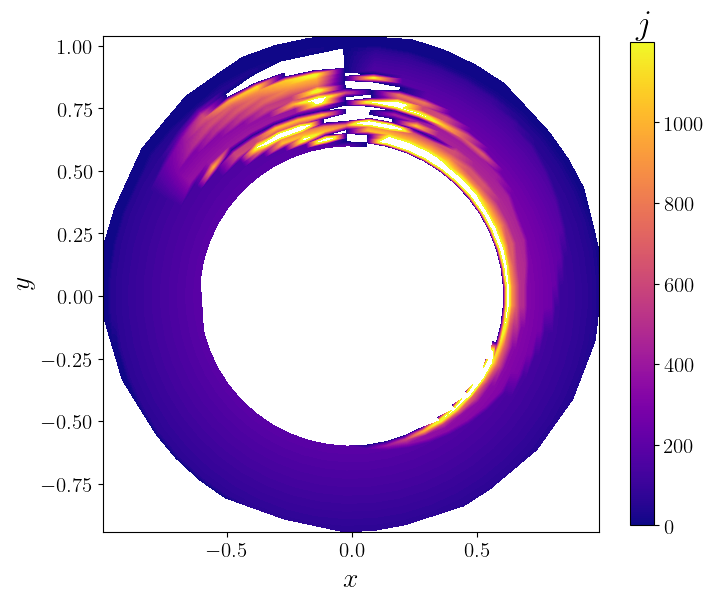

In [34]:
%matplotlib inline
import matplotlib.tri as tri

# sigmaMinus_xMesh = sigmaMinus_xMesh.reshape(-1,1)
# sigmaMinus_yMesh = sigmaMinus_yMesh.reshape(-1,1)
# norm = mpl.colors.Normalize(vmin=np.nanmin(sigmaMinus_bounce[:,0]), vmax=np.nanmax(sigmaMinus_bounce[:,0]))
norm = mpl.colors.Normalize(vmin=np.nanmin(sigmaMinus_jMesh), vmax=np.nanmax(sigmaMinus_jMesh))

mask_radius = field_parameters[0] - 0.4 # minor radius = 0.4
triang = tri.Triangulation(sigmaMinus_xMesh, sigmaMinus_yMesh)

# Mask off unwanted triangles outside of r < major radius - minor radius
xmid = sigmaMinus_xMesh[triang.triangles].mean(axis=1)
ymid = sigmaMinus_yMesh[triang.triangles].mean(axis=1)
mask = np.where(xmid*xmid + ymid*ymid < mask_radius*mask_radius, 1, 0)
triang.set_mask(mask)

jvalues_ignore = np.equal(temp_jMesh, 0)
mask_nanvalues = np.all(np.where(jvalues_ignore[triang.triangles], True, False), axis = 1)
triang.set_mask(mask | mask_nanvalues)


# isbad = np.less(z, 1.4) | np.greater(z, 2.1)

# triang = tr.Triangulation(x, y)
# mask = np.all(np.where(isbad[triang.triangles], True, False), axis=1)
# triang.set_mask(mask)
# colplt = mp.tricontourf(triang, z)
# mp.colorbar()

fig = plt.figure(figsize=(8,8), dpi = 100)
ax = fig.add_subplot(111)
# ax.triplot(triang,'-bo')
# ax.scatter(sigmaMinus_xMesh, sigmaMinus_yMesh, s = 2, c = sigmaMzinus_bounce[:, 0])
# ax.scatter(sigmaMinus_xMesh, sigmaMinus_yMesh, s = 3, c = temp_jMesh)
# plt.tricontour(sigmaMinus_xMesh, sigmaMinus_yMesh, sigmaMinus_jMesh.squeeze(), 1000)
# plt.tricontourf(triang, sigmaMinus_zMesh, 50)
plt.tricontourf(triang, temp_jMesh, levels = np.linspace(0,500,100), cmap = 'plasma')
# plt.tricontour(triang, temp_jMesh.squeeze(), 100)
sm = plt.cm.ScalarMappable(cmap = cm.plasma, norm=norm)
cbar = fig.colorbar(sm, ax = ax, shrink = 0.8)
cbar.ax.set_title(r'$j$', fontsize = 25)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_aspect('equal')
# plt.savefig('sigma_surface_formI_C%.2f'%(field_parameters[1]) + \
#             'epsilon%.2f'%(field_parameters[2]) + 'jcontour.pdf',bbox_inches = 'tight')
# plt.savefig('sigma_surface_formI_C%.2f'%(field_parameters[1]) + \
#             'epsilon%.2f'%(field_parameters[2]) + 'jcontour.png',dpi = 300, bbox_inches = 'tight')
plt.show()

### Visualize guiding center trajectories in 2D and 3D

__Plot the guiding center trajectories when integrated backward__

In [23]:
%matplotlib

sol = sol_fieldline_flow
majorRad = field_parameters[0]
minorRad = 0.4 # check if the code for generating sigma has the same minor radii

dtEval = 0.01
tEval = np.arange(sol.t[0], sol.t[-1] + dtEval, dtEval)
solEval = sol.sol(tEval) #in cartesian coordinates

# solFieldMag = np.sqrt(field_parameters[1]**2 + solEval[2,:]**2 + \
#                       (np.sqrt(solEval[0,:]**2 + solEval[1,:]**2) - \
#                        field_parameters[0])**2)/np.sqrt(solEval[0,:]**2 + solEval[1,:]**2)

solEval_R = np.linalg.norm(solEval[0:2,:], axis = 0)
solEval_phi = np.arctan2(solEval[1, :], solEval[0, :])
solEval_z = solEval[2,:]
solEval_cyl = np.array([solEval_R, solEval_phi, solEval_z]).T
solFieldMag = toy_tokamak.field_mag(solEval_cyl, field_parameters)

fig, ax = plt.subplots(4,1, figsize=(10,10), dpi = 100)
# plt.scatter(xMesh, yMesh, s = 1)
# plt.scatter(y0[0], y0[1], s = 15, c = 'g')
# plt.plot(solEval[0,:],solEval[1,:],'-b', lw = 1)
ax[0].plot(tEval[:-1], solEval_R[:-1] - field_parameters[0], '-k', lw = 1)
ax[0].set_ylabel(r'$r$', fontsize = 20)

ax[1].plot(tEval[:-1], solEval[2,:-1], '-k', lw = 1)
ax[1].set_ylabel(r'$z$', fontsize = 20)

# ax[2].plot(tEval, 0.5*solEval[3,:]**2 + solFieldMag, '-k', lw = 1)
ax[2].plot(tEval[:-1], solFieldMag[:-1], '-k', lw = 2, label = r'$|B|$')
ax[2].plot(tEval[:-1], np.sqrt(2*(initialEnergy - solFieldMag[:-1])), '-r', lw = 2, label = r'$v_{||}$')
# ax[2].plot(tEval, solEval[3,:]**2, '-k', lw = 1)
# ax[2].set_ylabel(r'$v_{||}$', fontsize = 20)
ax[2].grid('on')
ax[2].legend(fontsize = 15)
# ax[2].set_xlabel(r'$t$', fontsize = 20)

# ax[3].plot(tEval[:-1], solEval[3,:-1], '-k', lw = 1)
# ax[3].set_ylabel(r'$j$', fontsize = 20)
ax[3].plot(tEval[:-1], solEval_phi[:-1], '-k', lw = 1)
ax[3].set_ylabel(r'$\phi$', fontsize = 20)
ax[3].set_xlabel(r'$t$', fontsize = 20)
# plt.plot(tEval, solEval[4,:], '-k', lw = 1)


# fig = plt.figure(figsize=(6,6), dpi=130)
# ax = fig.add_subplot(111, projection='3d')
# ax = toy_tokamak.plot_torus(50, majorRad, minorRad, ax)
# ax.plot3D(solEval[0,:], solEval[1,:], solEval[2,:], '-b', lw = 2)
# plt.show()

# ax.plot_surface(xMesh, yMesh, zMesh, alpha = 0.2, antialiased = True)
# ax.scatter3D(y0[0], y0[1], y0[2], s = 15)
plt.show()



Using matplotlib backend: MacOSX


## Plotting the backward guiding center trajectory

In [60]:
%matplotlib

sol = sol_parallel_vel
dvEval = 0.01
vEval = np.arange(sol.t[0], sol.t[-1], dvEval)
solEval = sol.sol(vEval) #in cartesian coordinates

solEval_R = np.linalg.norm(solEval[0:2,:], axis = 0)
solEval_phi = np.arctan2(solEval[1, :], solEval[0, :])
solEval_z = solEval[2,:]
solEval_cyl = np.array([solEval_R, solEval_phi, solEval_z]).T
solFieldMag = toy_tokamak.field_mag(solEval_cyl, field_parameters)


fig, ax = plt.subplots(4,1, figsize=(10,10), dpi = 100)
# plt.scatter(xMesh, yMesh, s = 1)
# plt.scatter(y0[0], y0[1], s = 15, c = 'g')
# plt.plot(solEval[0,:],solEval[1,:],'-b', lw = 1)
ax[0].plot(vEval, solEval_R - field_parameters[0], '-k', lw = 1)
ax[0].set_ylabel(r'$r$', fontsize = 20)

ax[1].plot(vEval, solEval[2,:], '-k', lw = 1)
ax[1].set_ylabel(r'$z$', fontsize = 20)

# ax[2].plot(tEval, 0.5*solEval[3,:]**2 + solFieldMag, '-k', lw = 1)
ax[2].plot(vEval, solFieldMag, '-k', lw = 2, label = r'$|B|$')
ax[2].plot(vEval, np.sqrt(2*(initialEnergy - solFieldMag)), '-r', lw = 2, label = r'$v_{||}$')
# ax[2].plot(tEval, solEval[3,:]**2, '-k', lw = 1)
# ax[2].set_ylabel(r'$v_{||}$', fontsize = 20)
ax[2].grid('on')
ax[2].legend(fontsize = 15)
# ax[2].set_xlabel(r'$t$', fontsize = 20)

# ax[3].plot(tEval, solEval[3,:], '-k', lw = 1)
# ax[3].set_ylabel(r'$j$', fontsize = 20)
ax[3].plot(vEval, solEval_phi, '-k', lw = 1)
ax[3].set_ylabel(r'$\phi$', fontsize = 20)
ax[3].set_xlabel(r'$v_{||}$', fontsize = 20)
# plt.plot(tEval, solEval[4,:], '-k', lw = 1) 

Using matplotlib backend: MacOSX


AttributeError: 'FigureCanvasMac' object has no attribute '_set_device_pixel_ratio'

AttributeError: 'FigureCanvasMac' object has no attribute 'device_pixel_ratio'

/var/folders/2s/q3w7g43d6tnf4qqx2l_wjqj00000gp/T/ipykernel_7293/4196055502.py:27: RuntimeWarning: invalid value encountered in sqrt
  ax[2].plot(vEval, np.sqrt(2*(initialEnergy - solFieldMag)), '-r', lw = 2, label = r'$v_{||}$')


Text(0.5, 0, '$v_{||}$')

## Plotting the sigma surface in toroidal-poloidal coordinates

In [ ]:
#     if np.size(sol_fieldline_flow.t_events[0]) == 0:
#         sigmaMinus_bounce[initialcondID,0] = np.NaN
#         sigmaMinus_bounce[initialcondID,1:] = np.NaN
#         sigmaMinus_jMesh[initialcondID, 0] = np.NaN

#         finishedFlag = True
#         continue

#     while finishedFlag == False:
#         modB_endpt = toy_tokamak.field_mag(toy_tokamak.cart_to_cyl(np.reshape(sol_fieldline_flow.y[:3,-1], (1,3))), \
#                                          field_parameters)
#         print('Energy at the crossing of Sigma^- %.12e'%(modB_endpt))
#         # parallel_vel = np.sqrt(2.0*(initialEnergy - modB_endpt))
#         # print('Parallel velocity: %.12e'%(parallel_vel))

#         if modB_endpt > initialEnergy:
#             # Find bounce time and compute j for the fieldline
#             print('Will bounce before crossing Sigma^-')

#             # Integrate without the j time-derivative with the h = |B| event to find the bounce point
#             sol_fieldline_flow = solve_ivp(toy_tokamak.fieldline_flow, \
#                                            [sol_fieldline_flow.t[0], sol_fieldline_flow.t_events[0]], \
#                                            y0, args = field_parameters, events = bounce_cond_modB, \
#                                            dense_output = True, atol=1.e-10, rtol=1.e-8)
            
        
#             # print('Bounce time %.12e'%(sol_fieldline_flow.t_events[0])) 
#             # sigmaMinus_bounce[initialcondID,0] = sol_fieldline_flow.t_events[0]
#             totalTimeToBounce += sol_fieldline_flow.t_events[0]
#             print('Bounce time %.12e'%(totalTimeToBounce)) 
#             sigmaMinus_bounce[initialcondID,0] = totalTimeToBounce
            
#             sigmaMinus_bounce[initialcondID,1:] = sol_fieldline_flow.y_events[0][0][:3]

#             # Integrate with the j time-derivative 
#             if numSigmaMinusCross == 0:
#                 longAdiaInv = initialLongAdiaInv
                
#             y0 = np.append(y0, longAdiaInv)
#             sol_fieldline_flow = solve_ivp(toy_tokamak.fieldline_flow, \
#                                            [sol_fieldline_flow.t[0], sol_fieldline_flow.t_events[0]], \
#                                            y0, args = field_parameters, 
#                                            dense_output = True, atol=1.e-10, rtol=1.e-8)

#             print('Longitudinal adiabatic invariant, j = %.12e'%(sol_fieldline_flow.y[-1,-1]))
#             sigmaMinus_jMesh[initialcondID, 0] = sol_fieldline_flow.y[-1,-1]
            
#             finishedFlag = True
#         elif modB_endpt < initialEnergy:
#             print('Will cross Sigma^-')
#             # Update j
#             if numSigmaMinusCross == 0:
#                 longAdiaInv = initialLongAdiaInv
            
#             y0 = np.append(y0[:3], longAdiaInv)
                
#             sol_fieldline_flow_j = solve_ivp(toy_tokamak.fieldline_flow, \
#                                            [sol_fieldline_flow.t[0], sol_fieldline_flow.t_events[0]], \
#                                            y0, args = field_parameters, 
#                                            dense_output = True, atol=1.e-10, rtol=1.e-8)
#             print('Time interval %.12e, %.12e'%(sol_fieldline_flow_j.t[0], sol_fieldline_flow_j.t[-1]))
            
#             longAdiaInv += sol_fieldline_flow_j.y[-1,-1]
#             numSigmaMinusCross += 1
            
#             # print('Longitudinal adiabatic invariant, j = %.12e'%(sol_fieldline_flow.y[-1,-1]))
#             # sigmaMinus_jMesh[initialcondID, 0] = sol_fieldline_flow.y[-1,-1]
            
#             print('Longitudinal adiabatic invariant, j = %.12e'%(longAdiaInv))
        
#             print('Integrating until the next crossing ...')
#             y0 = sol_fieldline_flow_j.y[:3,-1]
#             del sol_fieldline_flow
#             sol_fieldline_flow = solve_ivp(toy_tokamak.fieldline_flow, \
#                                            [sol_fieldline_flow_j.t[-1], fieldline_time_final], \
#                                            y0, args = field_parameters, \
#                                            events = bounce_cond_sigmaminus, \
#                                            dense_output = True, atol=1.e-10, rtol=1.e-8) 
#             print('Time interval %.12e, %.12e'%(sol_fieldline_flow.t[0], sol_fieldline_flow.t[-1]))
            
#         elif np.abs(initialEnergy - modB_endpt) < 1.e-10:
#             print('Will asymptote to Sigma^-')
#             # Undefined j for this point
#             sigmaMinus_bounce[initialcondID,0] = np.NaN
#             sigmaMinus_bounce[initialcondID,1:] = np.NaN
#             sigmaMinus_jMesh[initialcondID, 0] = np.NaN

#             finishedFlag = True
#             break
        
        
        

#Now integrate backwards until v = 0 to land precisely on the bounce point on the sigma-minus surface
#         vInitial = -parallel_vel
#         vFinal = 0
#         # gc0 = np.append(sol_fieldline_flow.y[:3,-1],0)
#         gc0 = sol_fieldline_flow.y[:,-2]
#         # field_parameters[-1] = modB_endpt
#         sol_parallel_vel = solve_ivp(toy_tokamak.zgcm_vpar_flow, [vInitial, vFinal], gc0, args = field_parameters, \
#                        dense_output = True, atol=1.e-10, rtol=1.e-8)
#         print('Longitudinal adiabatic invariant, j = %.12e'%(sol_parallel_vel.y[-1,-1]))

#         sigmaMinus_jMesh[initialcondID, 0] = sol_parallel_vel.y[-1,-1]